In [2]:
import os
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
import scipy.sparse as sparse
font = {'family' : 'Arial',
        'size'   : 14}


In [3]:
import jax
print(jax.__version__)

0.4.8


In [14]:
import jaxlib
print(jaxlib.__version__)

0.4.7


In [15]:
import chex
print(chex.__version__)

0.1.7


In [4]:
train = sc.read("./data/train.h5ad",backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


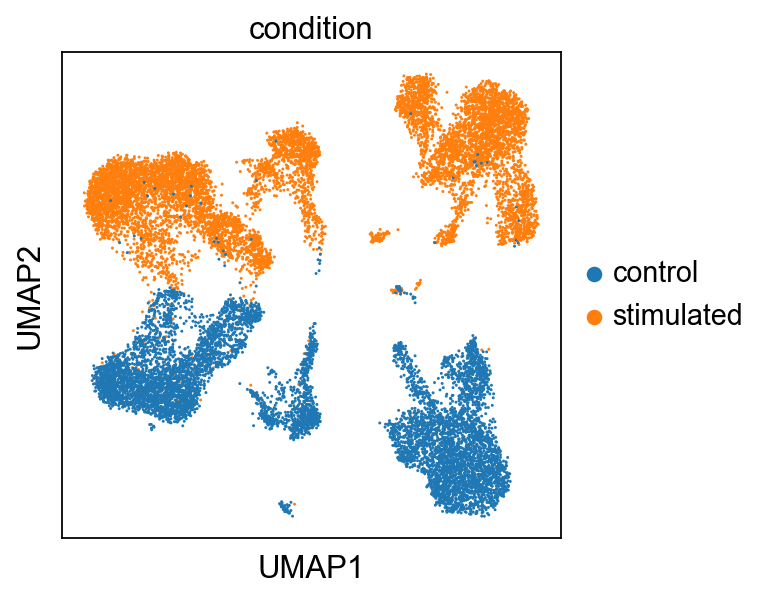

In [12]:

sc.pl.umap(train, color=['condition'], cmap='Reds')

In [21]:
#delete CD4T stimulated data
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]

In [48]:
print(train_new)

AnnData object with n_obs × n_vars = 13766 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


In [23]:
train_new=train_new.copy()
scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")

In [24]:
model = scgen.SCGEN(train_new)


In [166]:
# model.save("./saved_models/model_perturbation_prediction.pt", overwrite=True)
scgen_model=scgen.SCGEN.load("scgen_model",train_new)

INFO     File scgen_model/model.pt already downloaded                                                              


In [51]:
model.train(
        max_epochs=10,
        batch_size=32,
        early_stopping=True,
        early_stopping_patience=25
)

Epoch 28/100:  28%|██▊       | 28/100 [15:20<39:26, 32.87s/it, loss=74.6, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 619.285. Signaling Trainer to stop.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 10/10: 100%|██████████| 10/10 [05:33<00:00, 33.32s/it, loss=71, v_num=1]  


In [153]:
# from scvi.model import SCVI, SCANVI
# model = SCVI.load("test_model/", train_new)

INFO     File test_model/model.pt already downloaded                                                               
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/12/d54y_pk95zdbftjg_qkcj_c80000gq/T/ipykernel_57841/2708985316.py", line 2, in <module>
    model = SCVI.load("test_model/", train_new)
  File "/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/scvi/model/base/_base_model.py", line 611, in load
    cls.setup_anndata(adata, source_registry=registry, **registry[_SETUP_ARGS_KEY])
  File "/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/scvi/model/_scvi.py", line 190, in setup_anndata
    adata_manager.register_fields(adata, **kwargs)
  File "/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/scvi/data/_manager.py", line 156, in register_fields
    ] = field.transfer_field(
  File "/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-package

In [59]:
import joblib
joblib.dump(model, 'my_scgen_model.joblib')

['my_scgen_model.joblib']

In [61]:
model2 = joblib.load('my_scgen_model.joblib')

In [62]:
latent_X = model2.get_latent_representation()

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [63]:
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


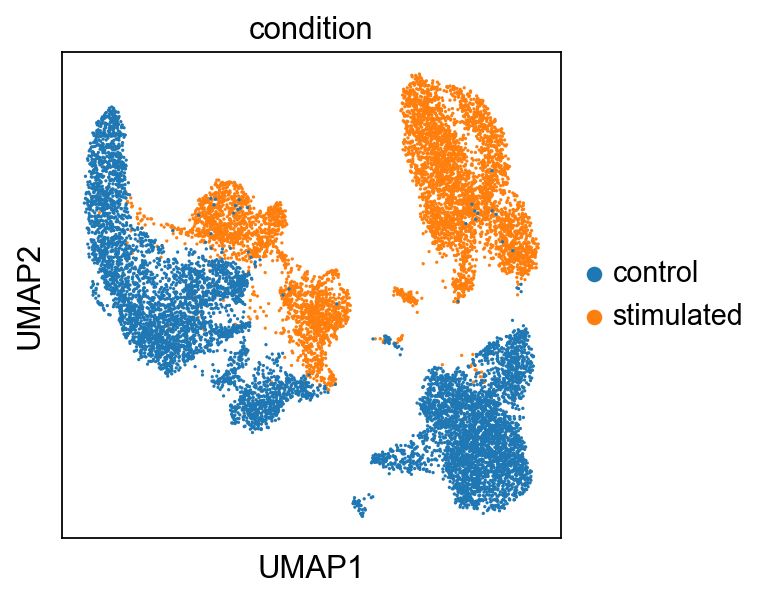

In [66]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition'], cmap='Reds')

In [68]:
pred, delta = model2.predict(
        ctrl_key='control',
        stim_key='stimulated',
        celltype_to_predict='CD4T'
)
#we set "ctrl" to our control labels and "stim" to our stimulated labels.

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [167]:
pred2, delta2 = scgen_model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [155]:
pred

AnnData object with n_obs × n_vars = 2437 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol', 'n_cells'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [74]:
pred.obs['condition']='pred'

In [75]:
ctrl_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from flo

In [168]:
eval_adata2 = ctrl_adata.concatenate(stim_adata, pred2)

/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from flo

/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


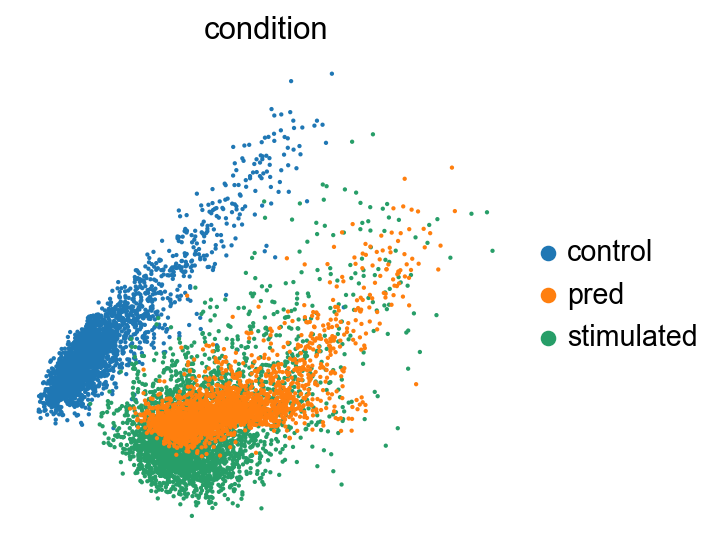

In [77]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False)

In [79]:
CD4T = train[train.obs["cell_type"] =="CD4T"]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
CD4T.uns['rank_genes_groups']

/Users/meiqiliu/miniforge3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


{'params': {'groupby': 'condition',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('FTH1', 'ISG15'), ('RGCC', 'IFI6'), ('FTL', 'ISG20'), ...,
            ('ISG20', 'FTL'), ('IFI6', 'RGCC'), ('ISG15', 'FTH1')],
           dtype=[('control', 'O'), ('stimulated', 'O')]),
 'scores': rec.array([( 23.932802,  62.22936 ), ( 22.58155 ,  58.841118),
            ( 17.054861,  56.727085), ..., (-56.727085, -17.054861),
            (-58.841118, -22.58155 ), (-62.22936 , -23.932802)],
           dtype=[('control', '<f4'), ('stimulated', '<f4')]),
 'pvals': rec.array([(1.39574450e-126, 0.00000000e+000),
            (6.57981147e-113, 0.00000000e+000),
            (3.21638465e-065, 0.00000000e+000), ...,
            (0.00000000e+000, 3.21638465e-065),
            (0.00000000e+000, 6.57981147e-113),
            (0.00000000e+000, 1.39574450e-126)],
           dtype=[('control', '<f8'), ('stimulated', '<f8'

In [85]:
print(CD4T)
CD4T.uns['rank_genes_groups']['names']# condi: control, stim

AnnData object with n_obs × n_vars = 5564 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


rec.array([('FTH1', 'ISG15'), ('RGCC', 'IFI6'), ('FTL', 'ISG20'), ...,
           ('ISG20', 'FTL'), ('IFI6', 'RGCC'), ('ISG15', 'FTH1')],
          dtype=[('control', 'O'), ('stimulated', 'O')])

In [86]:
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)
#genes that has most difference between the stim and ctrl group

['ISG15' 'IFI6' 'ISG20' ... 'FTL' 'RGCC' 'FTH1']


In [88]:
r2_value = model2.reg_mean_plot(
        eval_adata,
        axis_keys={"x": "pred", "y": "stimulated"},
        gene_list=diff_genes[:10],
        labels={"x": "predicted", "y": "ground truth"},
        #path_to_save="./reg_mean1.pdf",
        show=True,
        legend=False
)

In [91]:
r2_value

0.9584801945824667

In [108]:
model2.reg_mean_plot(
    eval_adata,
    #axis_keys={"x": "ctrl", "y": "stimulated"},
    axis_keys={"x": "control", "y": "pred"},
    gene_list=diff_genes[:10],
    labels={"x": "ctrl", "y": "pred stim"},
    path_to_save="./reg_mean2.pdf",
    show=True,
    legend=False
)

0.8499170069036006

In [111]:
model2.reg_mean_plot(
    eval_adata,
    #axis_keys={"x": "ctrl", "y": "stimulated"},
    axis_keys={"x": "control", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "ctrl", "y": "true stim"},
    #path_to_save="./reg_mean3.pdf",
    show=True,
    legend=False
)

0.8672060325149121

In [ ]:
scgen_model.reg_mean_plot(
    eval_adata2,
    #axis_keys={"x": "ctrl", "y": "stimulated"},
    axis_keys={"x": "control", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "ctrl", "y": "true stim"},
    #path_to_save="./reg_mean3.pdf",
    show=True,
    legend=False
)

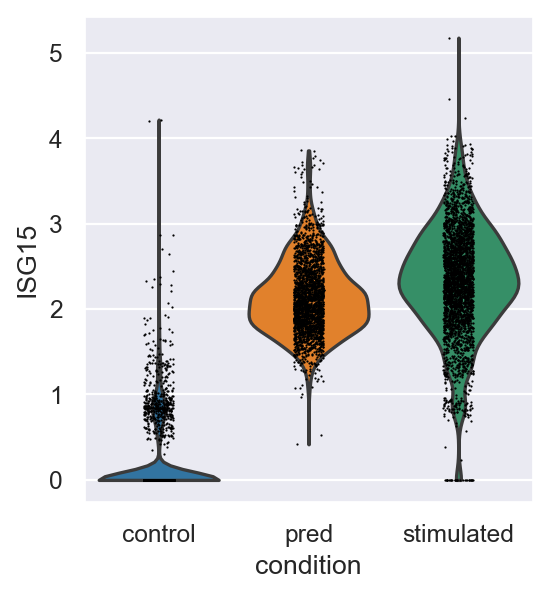

In [112]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

In [125]:
def calc_Pearson(adata, cell_type, n_genes=6998, conditions=None):
    if n_genes != adata.shape[1]:
        celldata = adata.copy()[adata.obs["cell_type"] == cell_type]
        print(celldata.obs["condition"].unique().tolist())
        sc.tl.rank_genes_groups(celldata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = celldata.uns["rank_genes_groups"]["names"][conditions["real_stim"]]
        adata = adata[:, diff_genes.tolist()]

    real_stim = adata[adata.obs["condition"] == conditions["x"]]
    pred_stim = adata[adata.obs["condition"] == conditions["y"]]

    x = np.asarray(np.mean(pred_stim.X, axis=0)).ravel()
    y = np.asarray(np.mean(real_stim.X, axis=0)).ravel()

    df = pd.DataFrame({'x':x, 'y':y})

    # compute pearson correlation
    r = df['x'].corr(df['y'])

    return r
# cell_types = ["B", "CD14-Mono", "CD4-T", "CD8-T", "DC", "F-Mono", "NK"]
conditions = {"x": "stimulated", "y": "pred"}
calc_Pearson(eval_adata,"CD4T",n_genes=6998,conditions=conditions)

0.9790200174574911

In [126]:
train.obs["cell_type"].values
print(eval_adata.shape)
conditions = {"x": "control", "y": "pred"}
calc_Pearson(eval_adata,"CD4T",n_genes=6998,conditions=conditions)

(8001, 6998)


0.921909435304575

In [127]:
conditions = {"x": "control", "y": "stimulated"}
calc_Pearson(eval_adata,"CD4T",n_genes=6998,conditions=conditions)

0.9312389771239776

In [136]:
from sklearn.metrics import mean_absolute_error
def calc_mae(adata, cell_type, n_genes=6998, conditions=None):
    if n_genes != adata.shape[1]:
        celldata = adata.copy()[adata.obs["cell_type"] == cell_type]
        print(celldata.obs["condition"].unique().tolist())
        sc.tl.rank_genes_groups(celldata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = celldata.uns["rank_genes_groups"]["names"][conditions["real_stim"]]
        adata = adata[:, diff_genes.tolist()]
    real_stim = adata[adata.obs["condition"] == conditions["x"]]
    pred_stim = adata[adata.obs["condition"] == conditions["y"]]
    x = np.asarray(np.mean(pred_stim.X, axis=0)).ravel()
    y = np.asarray(np.mean(real_stim.X, axis=0)).ravel()
    #if actual value is y and predicted value is x
    mae=np.mean(np.abs(np.array(y) - np.array(x)))
    statistic, p_value = stats.wilcoxon(x-y)

# Output the test results
    print("Wilcoxon signed-rank statistic:", statistic)
    print("p-value:", p_value)
    print("mae:",mean_absolute_error(y,x))
    return mae
# cell_types = ["B", "CD14-Mono", "CD4-T", "CD8-T", "DC", "F-Mono", "NK"]
conditions = {"x": "stimulated", "y": "pred"}
calc_mae(eval_adata,"CD4T",n_genes=6998,conditions=conditions)

Wilcoxon signed-rank statistic: 0.0
p-value: 0.0
mae: 0.042353895


0.042353895

In [140]:
conditions = {"x": "control", "y": "stimulated"}
calc_mae(eval_adata,"CD4T",n_genes=6998,conditions=conditions)

Wilcoxon signed-rank statistic: 7062441.0
p-value: 4.011495784797428e-167
mae: 0.011436838


0.011436838

In [142]:
conditions = {"x": "control", "y": "control"}
calc_Pearson(eval_adata,"CD4T",n_genes=6998,conditions=conditions)

1.0